<a href="https://colab.research.google.com/github/RashaAlshawi/Sinkhole-Detection-using-ML/blob/main/Deep%20Learning%20Models/Depth_Wise_Searable_U_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import Libraries 
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras import backend as K
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPool2D,concatenate,Conv2DTranspose
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras import regularizers

import datetime
#import tensorflow_addons as tfa

# Loading Sinkhole Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
X_P=np.load('/content/drive/MyDrive/Colab Notebooks/sinkholedataset/PosX.npy')
y_P=np.load('/content/drive/MyDrive/Colab Notebooks/sinkholedataset/Posy.npy')
X_N=np.load('/content/drive/MyDrive/Colab Notebooks/sinkholedataset/NegX.npy')
y_N=np.load('/content/drive/MyDrive/Colab Notebooks/sinkholedataset/Negy.npy')

In [ ]:
(X_P.shape,y_P.shape),(X_N.shape,y_N.shape)

In [12]:
X_data=np.concatenate((X_P,X_N))
y_data=np.concatenate((y_P,y_N))

In [5]:
#Shuffle the dataset
X_datas,y_datas=shuffle((X_data,y_data),random_state=0)

In [6]:
#@title Dataset Normalization 
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

In [7]:
X_datas=normalize(X_datas)

In [9]:
# Splitting the Dataset into train and test
# 85% train and validation, 15% for test
samples_train=int((X_datas.shape[0])*0.85)
#samples_test=int(len(X_datas.shape[0])*0.85)

In [18]:
X_train=X_datas[:samples_train]
y_train=y_datas[:samples_train]
X_test=y_datas[samples_train:]
y_test=y_datas[samples_train:]

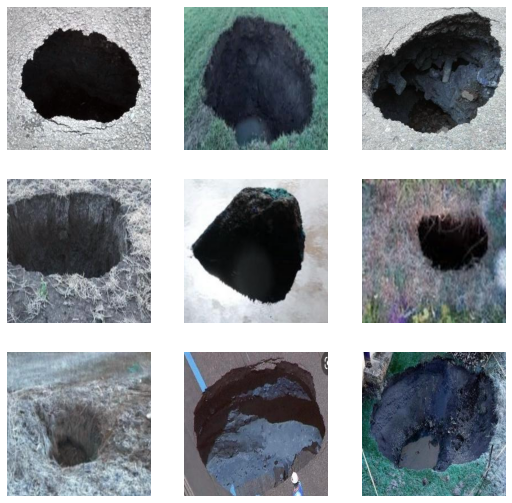

In [20]:
#@title Visualizing samples from Sinkhole Dataset
n_col=3
n_row=3
i=10
plt.figure(figsize=(n_col*3,n_row*3))
for rows in range(n_row):
    for cols in range(n_col):
        index= n_col*rows+cols
        plt.subplot(n_row,n_col,index+1)
        plt.axis('off')
        plt.imshow(X_train[i])
        i+=1
plt.show()
                

## Parameters 

In [21]:
# Input Dimensions 
IMG_Width=256
IMG_Hight=256
IMG_Channels=3
input_shape=(IMG_Hight,IMG_Width,IMG_Channels)

In [22]:
activation='relu'
activation2=None
BatchNorm=False
BatchNorm2=False 
learning_rate = 0.001
epochs=200
decay_rate = learning_rate / epochs

In [23]:
initializer = None#tf.keras.initializers.HeNormal(seed=None)
regularizer=None#regularizers.L1L2(l1=0.4, l2=0.3)

## Metrics

In [24]:
def jaccard_coef(y_true, y_pred):
    "Intersection over Union IOU"
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0) # changed 1.0 to 1 

In [25]:
def jacard_coef_loss(y_true, y_pred):
  x=-jaccard_coef(y_true, y_pred)
  return x

In [26]:
opt1=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.5)
opt2=tf.keras.optimizers.Adadelta(
  learning_rate=learning_rate, rho=0.95, epsilon=1e-07, name="Adadelta" ) 

In [27]:
#loss=tfa.losses.GIoULoss()
loss=tf.keras.losses.BinaryCrossentropy(
    from_logits=True,   
    label_smoothing=0.0,
    axis=-1,
    reduction="auto",
    name="binary_crossentropy",
)

## Callbacks

In [29]:
filepath='/content/drive/MyDrive/Sinkhole_models/my_mode/bestinception'

In [31]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
# learning rate
def exp_decay(epochs,lr=learning_rate):
    if epochs <20:
       return lr
    else:
        return lr * np.exp(-decay_rate*epochs)

In [ ]:
lr_rate = tf.keras.callbacks.LearningRateScheduler(exp_decay)

In [32]:
my_callbacks=[
              tf.keras.callbacks.EarlyStopping(patience=40),
              tf.keras.callbacks.ModelCheckpoint(
                   filepath,save_best_only=True,monitor='val_loss'),
                  tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)]

## Depth Wise Separable U-Net

In [34]:
#@title convblock
def convblock(inputs,n_filters,size=3):

  conv=Conv2D(n_filters,(size,size),padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(inputs)
  
  conv=Conv2D(n_filters,(size,size),padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(conv)
  return conv

In [33]:
def convblock(inputs,n_filters,size=3,activation=activation,batchnormalization=BatchNorm):

  conv=Conv2D(n_filters,(size,size),padding='same')(inputs)
  if batchnormalization==True:
    conv=BatchNormalization()(conv)
  conv=tf.keras.layers.Activation(activation)(conv)
  conv=Conv2D(n_filters,(size,size),padding='same')(conv)
  if batchnormalization==True:
    conv=BatchNormalization()(conv)
  conv=tf.keras.layers.Activation(activation)(conv)
  return conv

In [37]:
def inception_sepconvblock(inputs,f1,f2,f3):
    "Depth wise Separable Icpetion block"
    conva = SeparableConv2D(f1, (3, 3), activation=activation, padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(inputs)
    conva = SeparableConv2D(f1, (3, 3), activation=activation, padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(conva)
    
    convb = SeparableConv2D(f2, (5, 5), activation=activation, padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(inputs)
    convb = SeparableConv2D(f2, (5, 5), activation=activation, padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(convb)


    convc=MaxPool2D((3,3),strides=(1,1),padding='same')(inputs)
    convc=Conv2D(f3,(1,1),padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(convc)
    

    concatenated = concatenate([conva, convb, convc])
  
    return concatenated

In [38]:
def DepthWise_U_Net(dropout_rate=0.0):
  "Depth Wise Separable U-Net"
  inputs=tf.keras.layers.Input(shape=input_shape)
  #````encoder`````
  conv1=convblock(inputs,64,3)
  max1=MaxPool2D((2,2))(conv1)
  conv2=inception_sepconvblock(max1,f1=84,f2=28,f3=16) #128
  max2=MaxPool2D((2,2))(conv2)
  conv3=inception_sepconvblock(max2,f1=128,f2=100,f3=28) #256
  max3=MaxPool2D((2,2))(conv3)
  conv4=inception_sepconvblock(max3,f1=256,f2=210,f3=46) #512
  max4=MaxPool2D((2,2))(conv4)
  conv5=inception_sepconvblock(max4,f1=512,f2=420,f3=92) #1024


  #````decoder`````
  
  u6=Conv2DTranspose(512,(2,2),strides=(2,2),padding='same',activation=activation2)(conv5)
  conct1=concatenate([u6,conv4])
  conv_4=inception_sepconvblock(conct1,f1=256,f2=210,f3=46)

  u7=tf.keras.layers.Conv2DTranspose(filters=256,kernel_size=(2,2),strides=(2,2),padding='same',activation=activation2)(conv_4)
  conct2=tf.keras.layers.concatenate([u7,conv3])
  conv_3=inception_sepconvblock(conct2,f1=128,f2=100,f3=28) #256
  u8=tf.keras.layers.Conv2DTranspose(filters=128,kernel_size=(2,2),strides=(2,2),padding='same',activation=activation2)(conv_3)
  conct3=tf.keras.layers.concatenate([u8,conv2])
  conv_2=inception_sepconvblock(conct3,f1=84,f2=28,f3=16) #128
  u9=tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(2,2),strides=(2,2),padding='same',activation=activation2)(conv_2)
  conct4=tf.keras.layers.concatenate([u9,conv1])
  conv_1=convblock(conct4,64,3)
  output=tf.keras.layers.Conv2D(filters=1,kernel_size=(1,1),activation='sigmoid')(conv_1)

  #output=tf.keras.layers.Reshape([256,256])(output)

  model=tf.keras.Model(inputs=[inputs],outputs=[output])
  return model

In [39]:
model=DepthWise_U_Net(0.2)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model,to_file='model.png')

In [ ]:
# Initializing tensorboard
!kill 674
%tensorboard --logdir logs

In [43]:
model.compile(optimizer=opt1,loss=loss,metrics=['accuracy',jaccard_coef])

In [45]:
#@title Training the model
history=model.fit(X_train,y_train,epochs=epochs,validation_split=0.15,batch_size=20,shuffle=True,callbacks=my_callbacks)

In [ ]:
# save the last model
model.save('/content/drive/MyDrive/Sinkhole_models/ModelJan11')

## Testing and Evaluating the model

In [ ]:
model.evaluate(X_test,y_test)

Sep cell


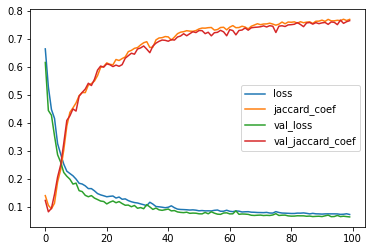

In [ ]:
c=pd.DataFrame(history.history)
c.to_csv('/content/drive/MyDrive/Sinkhole_models/histories/july_14')
pd.DataFrame(history.history).plot()

In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/Sinkhole_models/ModelJan11',compile=False)
model.compile(optimizer=opt1,loss=loss,metrics=['accuracy',jaccard_coef])

In [ ]:
y_predict=model.predict(X_test)

In [ ]:
y_predict=y_predict.reshape((y_predict.shape[0], 256, 256))

In [ ]:
#threshold to convert masks into binary 
y_predict_thr=(y_predict>0.37).astype(np.uint8)

In [ ]:
i=77
print('Sample:',i)
plt.imshow(X_test[i],cmap='gray')
plt.show()
plt.imshow(y_predict_thr[i],cmap='binary')

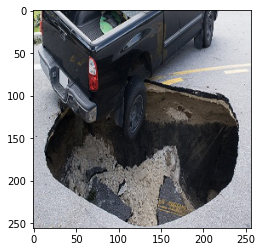

In [ ]:
img1=plt.imread('/content/c1096.jpg')
plt.imshow(img1)

## Hyperparametre Tuning 

In [ ]:
from keras.layers import Dropout
from sklearn.model_selection import GridSearchCV

In [ ]:
# requires model defined as a function, which we already have
from keras.wrappers.scikit_learn import KerasClassifier
batch_size = 20
epochs = 40

model = KerasClassifier(build_fn=model, 
                        epochs=epochs, 
                        batch_size = batch_size, 
                        verbose=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if __name__ == '__main__':


In [ ]:

#Also try softplus, tanh, linear, hard_sigmoid 
init_weights = ['uniform','glorot_uniform' 'normal', 'he_uniform']
#Also try lecun_uniform, he_normal, glorot_normal, etc. 

dropout_rate = [0.0, 0.2, 0.4]
weight_constraint = [1, 2, 3,5,4]
metric=['accuracy']

param_grid = dict(dropout_rate=dropout_rate, 
                  weight_constraint=weight_constraint,init_weights=init_weights)
              

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2,scoring='accuracy')


In [ ]:
grid_result = grid.fit(X_train, y_train)